# SegNet  
- Pytorch로 논문 구현  
- Data: CamVid (Kaggle)
    - Train: 369개, Valid: 100개, Test: 232개

# Packages and Modules

In [1]:
# packages and modules
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms  
import torchvision.models as models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [4]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv('./data/class_dict.csv', index_col=0)
data

r    g    b
name                            
Animal              64  128   64
Archway            192    0  128
Bicyclist            0  128  192
Bridge               0  128   64
Building           128    0    0
Car                 64    0  128
CartLuggagePram     64    0  192
Child              192  128   64
Column_Pole        192  192  128
Fence               64   64  128
LaneMkgsDriv       128    0  192
LaneMkgsNonDriv    192    0   64
Misc_Text          128  128   64
MotorcycleScooter  192    0  192
OtherMoving        128   64   64
ParkingBlock        64  192  128
Pedestrian          64   64    0
Road               128   64  128
RoadShoulder       128  128  192
Sidewalk             0    0  192
SignSymbol         192  128  128
Sky                128  128  128
SUVPickupTruck      64  128  192
TrafficCone          0    0   64
TrafficLight         0   64   64
Train              192   64  128
Tree               128  128    0
Truck_Bus          192  128  192
Tunnel              64    0   64
VegetationMisc     192  192    0
Void                 0    0    0
Wall                64  192    0

In [5]:
rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

In [6]:
# cuda setting
device = torch.device('cuda')
print(device)

cuda


In [7]:
num_classes = len(data) # 32 classes

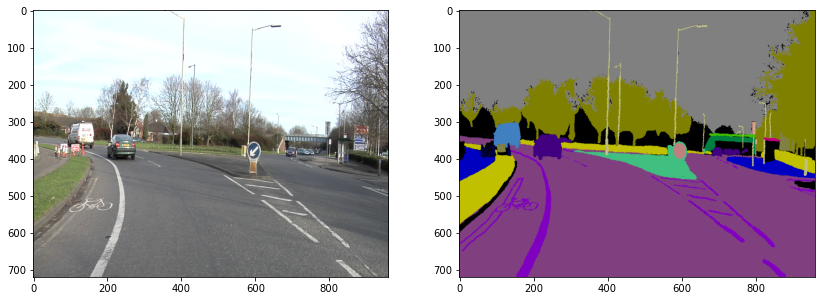

In [8]:
# show sample image
ex1 = Image.open('./data/train/train_images/0006R0_f00930.png')
ex2 = Image.open('./data/train/train_labels/0006R0_f00930_L.png')
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(ex1)
plt.subplot(122)
plt.imshow(ex2)
plt.show()

In [9]:
# load image data
def load_data(path, subset='train'):
    image_list, label_list = [], []
    image_files = glob(path+subset+'/'+subset+'_images/*.png')
    label_files = glob(path+subset+'/'+subset+'_labels/*.png')    
    for file in tqdm(image_files):
        img = Image.open(file)
        img = np.array(img)
        image_list.append(img)
    for file in tqdm(label_files):
        img = Image.open(file)
        img = np.array(img)
        label_list.append(img)
    return np.array(image_list), np.array(label_list)

path = './data/'
train_image, train_label = load_data(path, subset='train')
valid_image, valid_label = load_data(path, subset='valid')

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
# custom data set
class CamVidDataset(Dataset):
    def __init__(self, transforms_, subset='train'):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            self.images = train_image
            self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [12]:
batch_size = 12

transforms_ = [
    transforms.ToTensor(),
    transforms.Resize((224,224)),
]

train_loader = DataLoader(
    CamVidDataset(transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

valid_loader = DataLoader(
    CamVidDataset(transforms_, subset='valid'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

## Build Model

In [13]:
# define encoder block layers
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, last_layer=False):
        super(ConvBlock, self).__init__()
        # build encoder layer
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

In [14]:
class SegNet(nn.Module):
    def __init__(self, num_filters=64, in_dim=3, out_dim=num_classes):
        super(SegNet, self).__init__()
        
        # load vgg16 pre-trained model
        self.vgg16 = models.vgg16(pretrained=True)
        
        ### stage 1, 2 has 2 of Conv layer + Batch Norm layer + ReLU activation layer
        ### stage 3, 4, 5 has 3 of Conv layer + Batch Norm layer + ReLU activation layer
        
        ######################### ENCODER #########################
        # define max pooling layer
        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # first encoding
        self.encoder1 = ConvBlock(in_dim, num_filters)
        self.encoder2 = ConvBlock(num_filters, num_filters)
        # second encoding
        self.encoder3 = ConvBlock(num_filters, num_filters*2)
        self.encoder4 = ConvBlock(num_filters*2, num_filters*2)
        # third encoding
        self.encoder5 = ConvBlock(num_filters*2, num_filters*4)
        self.encoder6 = ConvBlock(num_filters*4, num_filters*4)
        self.encoder7 = ConvBlock(num_filters*4, num_filters*4)
        # fourth encoding
        self.encoder8 = ConvBlock(num_filters*4, num_filters*8)
        self.encoder9 = ConvBlock(num_filters*8, num_filters*8)
        self.encoder10 = ConvBlock(num_filters*8, num_filters*8)
        # fifth encoding
        self.encoder11 = ConvBlock(num_filters*8, num_filters*8)
        self.encoder12 = ConvBlock(num_filters*8, num_filters*8)
        self.encoder13 = ConvBlock(num_filters*8, num_filters*8)
                
        # get weights of pre-trained mode vgg16
        self.get_vgg_weights()
        
        ###########################################################
        ######################## SYMMETRIC ########################
        ###########################################################
        
        ######################### DECODER #########################
        # define max-pooling indices layer
        self.MaxUnPooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # first decoding
        self.decoder1 = ConvBlock(num_filters*8, num_filters*8)
        self.decoder2 = ConvBlock(num_filters*8, num_filters*8)
        self.decoder3 = ConvBlock(num_filters*8, num_filters*8)
        # second decoding
        self.decoder4 = ConvBlock(num_filters*8, num_filters*8)
        self.decoder5 = ConvBlock(num_filters*8, num_filters*8)
        self.decoder6 = ConvBlock(num_filters*8, num_filters*4)
        # third decoding
        self.decoder7 = ConvBlock(num_filters*4, num_filters*4)
        self.decoder8 = ConvBlock(num_filters*4, num_filters*4)
        self.decoder9 = ConvBlock(num_filters*4, num_filters*2)
        # fourth decoding
        self.decoder10 = ConvBlock(num_filters*2, num_filters*2)
        self.decoder11 = ConvBlock(num_filters*2, num_filters)
        # fifth decoding
        self.decoder12 = ConvBlock(num_filters, num_filters)
        self.decoder13 = ConvBlock(num_filters, out_dim)
        # softmax classifier
        self.classifier = nn.Softmax()
        
    def forward(self, x):
        ######################### ENCODING #########################
        # stage 1
        size1 = x.size()
        x = self.encoder1(x)
        x = self.encoder2(x)
        x, idx1 = self.MaxPooling(x)
        # stage 2
        size2 = x.size()
        x = self.encoder3(x)
        x = self.encoder4(x)
        x, idx2 = self.MaxPooling(x)
        # stage 3
        size3 = x.size()
        x = self.encoder5(x)
        x = self.encoder6(x)
        x = self.encoder7(x)
        x, idx3 = self.MaxPooling(x)
        # stage 4
        size4 = x.size()
        x = self.encoder8(x)
        x = self.encoder9(x)
        x = self.encoder10(x)
        x, idx4 = self.MaxPooling(x)
        # stage 5
        size5 = x.size()
        x = self.encoder11(x)
        x = self.encoder12(x)
        x = self.encoder13(x)
        x, idx5 = self.MaxPooling(x)
        
        ######################### DECODING #########################
        # stage 5
        x = self.MaxUnPooling(x, idx5, output_size=size5)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        # stage 4
        x = self.MaxUnPooling(x, idx4, output_size=size4)
        x = self.decoder4(x)
        x = self.decoder5(x)
        x = self.decoder6(x)
        # stage 3
        x = self.MaxUnPooling(x, idx3, output_size=size3)
        x = self.decoder7(x)
        x = self.decoder8(x)
        x = self.decoder9(x)
        # stage 2
        x = self.MaxUnPooling(x, idx2, output_size=size2)
        x = self.decoder10(x)
        x = self.decoder11(x)
        # stage 1
        x = self.MaxUnPooling(x, idx1, output_size=size1)
        x = self.decoder12(x)
        out = self.decoder13(x)
        # softmax activation function
        softmax_output = self.classifier(out)
        return out, softmax_output
    
    def get_vgg_weights(self):
        assert self.encoder1.block[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder1.block[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder2.block[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder2.block[0].weight.data = self.vgg16.features[2].weight.data
        
        assert self.encoder3.block[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder3.block[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder4.block[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder4.block[0].weight.data = self.vgg16.features[7].weight.data
        
        assert self.encoder5.block[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder5.block[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder6.block[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder6.block[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder7.block[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder7.block[0].weight.data = self.vgg16.features[14].weight.data
        
        assert self.encoder8.block[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder8.block[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder9.block[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder9.block[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder10.block[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder10.block[0].weight.data = self.vgg16.features[21].weight.data
        
        assert self.encoder11.block[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder11.block[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder12.block[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder12.block[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder13.block[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder13.block[0].weight.data = self.vgg16.features[28].weight.data

In [15]:
model = SegNet().to(device)
summary(model, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         ConvBlock-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
         ConvBlock-8         [-1, 64, 224, 224]               0
         MaxPool2d-9  [[-1, 64, 112, 112], [-1, 64, 112, 112]]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
        ConvBlock-13        [-1, 128, 112, 112]               0
           Conv2d-14    

# Set Loss function and Optimizer

In [16]:
lr = 0.0001
loss_func = nn.CrossEntropyLoss().to(device)
optim = optim.Adam(model.parameters(), lr=lr)

In [18]:
def train(model, 
          train_set, 
          valid_data,
          n_epochs):
    model.train()
    loss_list, val_loss_list = [], []
    staring = time.time()
    for epoch in tqdm(range(n_epochs)):
        init_time = time.time()
        for images, labels in train_set:
            images, labels = images.to(device), labels.to(device)
            
            optim.zero_grad()
            
            output_images, _ = model(images)
            loss = loss_func(output_images, labels)
            
            loss.backward()
            optim.step()
        end_time = time.time()
        loss_list.append(loss.item())
        print('[Epoch {}/{}]  [Loss: {}]  [time: {}s]'.format(epoch+1,
                                                              n_epochs,
                                                              round(loss.item(),4),
                                                              round(end_time-init_time,4)))
        
        with torch.no_grad():
            for val_images, val_labels in valid_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs, _ = model(val_images)
                val_loss = loss_func(val_outputs, val_labels)
                
            val_loss_list.append(val_loss.item())
            print(f'validation loss: {round(val_loss.item(),4)}')
        
    return model, loss_list, val_loss_list

In [19]:
EPOCH = 1000
model, train_loss, valid_loss = train(model, 
                                      train_loader, 
                                      valid_loader,
                                      n_epochs=EPOCH)

  0%|          | 0/500 [00:00<?, ?it/s]

[Epoch 1/500]  [Loss: 2.9284]  [time: 15.6389s]
validation loss: 2.8796
[Epoch 2/500]  [Loss: 2.6239]  [time: 11.6215s]
validation loss: 2.6083
[Epoch 3/500]  [Loss: 2.3758]  [time: 11.6556s]
validation loss: 2.374
[Epoch 4/500]  [Loss: 2.1762]  [time: 11.9556s]
validation loss: 2.1878
[Epoch 5/500]  [Loss: 2.0465]  [time: 11.665s]
validation loss: 2.0386
[Epoch 6/500]  [Loss: 2.0532]  [time: 12.0374s]
validation loss: 1.9527
[Epoch 7/500]  [Loss: 1.9131]  [time: 11.7987s]
validation loss: 1.9535
[Epoch 8/500]  [Loss: 1.8359]  [time: 11.8035s]
validation loss: 1.9482
[Epoch 9/500]  [Loss: 1.893]  [time: 11.8871s]
validation loss: 1.8513
[Epoch 10/500]  [Loss: 1.7551]  [time: 11.7995s]
validation loss: 1.8628
[Epoch 11/500]  [Loss: 1.7224]  [time: 11.852s]
validation loss: 1.8049
[Epoch 12/500]  [Loss: 1.757]  [time: 11.734s]
validation loss: 1.7925
[Epoch 13/500]  [Loss: 1.7006]  [time: 11.7555s]
validation loss: 1.9072
[Epoch 14/500]  [Loss: 1.7909]  [time: 11.8102s]
validation loss: 

[Epoch 115/500]  [Loss: 0.7772]  [time: 11.841s]
validation loss: 1.0123
[Epoch 116/500]  [Loss: 0.9384]  [time: 11.8s]
validation loss: 1.3068
[Epoch 117/500]  [Loss: 0.8566]  [time: 11.904s]
validation loss: 1.1553
[Epoch 118/500]  [Loss: 0.7661]  [time: 13.3137s]
validation loss: 1.2736
[Epoch 119/500]  [Loss: 0.8619]  [time: 12.293s]
validation loss: 1.1671
[Epoch 120/500]  [Loss: 0.821]  [time: 12.1067s]
validation loss: 1.3604
[Epoch 121/500]  [Loss: 0.8214]  [time: 12.0123s]
validation loss: 1.2211
[Epoch 122/500]  [Loss: 0.9168]  [time: 14.882s]
validation loss: 1.2348
[Epoch 123/500]  [Loss: 0.8934]  [time: 13.154s]
validation loss: 1.1426
[Epoch 124/500]  [Loss: 0.8877]  [time: 12.043s]
validation loss: 1.2267
[Epoch 125/500]  [Loss: 0.9229]  [time: 11.96s]
validation loss: 1.0843
[Epoch 126/500]  [Loss: 0.7893]  [time: 12.798s]
validation loss: 1.0929
[Epoch 127/500]  [Loss: 0.8364]  [time: 12.428s]
validation loss: 1.3162
[Epoch 128/500]  [Loss: 0.7914]  [time: 12.5667s]
va

validation loss: 0.9622
[Epoch 228/500]  [Loss: 0.5189]  [time: 11.941s]
validation loss: 1.1798
[Epoch 229/500]  [Loss: 0.518]  [time: 11.9172s]
validation loss: 0.8856
[Epoch 230/500]  [Loss: 0.5495]  [time: 11.893s]
validation loss: 0.9166
[Epoch 231/500]  [Loss: 0.499]  [time: 11.945s]
validation loss: 0.9559
[Epoch 232/500]  [Loss: 0.5683]  [time: 12.061s]
validation loss: 0.8972
[Epoch 233/500]  [Loss: 0.4345]  [time: 12.5003s]
validation loss: 0.9061
[Epoch 234/500]  [Loss: 0.5156]  [time: 12.368s]
validation loss: 0.8828
[Epoch 235/500]  [Loss: 0.4653]  [time: 11.963s]
validation loss: 0.8625
[Epoch 236/500]  [Loss: 0.4625]  [time: 11.944s]
validation loss: 0.97
[Epoch 237/500]  [Loss: 0.5353]  [time: 11.9576s]
validation loss: 0.9502
[Epoch 238/500]  [Loss: 0.4717]  [time: 11.781s]
validation loss: 1.0474
[Epoch 239/500]  [Loss: 0.5323]  [time: 11.712s]
validation loss: 1.0235
[Epoch 240/500]  [Loss: 0.5158]  [time: 11.646s]
validation loss: 0.9948
[Epoch 241/500]  [Loss: 0.46

validation loss: 0.8426
[Epoch 341/500]  [Loss: 0.3111]  [time: 11.641s]
validation loss: 0.7776
[Epoch 342/500]  [Loss: 0.2809]  [time: 11.655s]
validation loss: 0.6987
[Epoch 343/500]  [Loss: 0.3343]  [time: 11.646s]
validation loss: 0.8166
[Epoch 344/500]  [Loss: 0.2976]  [time: 11.751s]
validation loss: 0.8748
[Epoch 345/500]  [Loss: 0.2909]  [time: 11.714s]
validation loss: 0.7578
[Epoch 346/500]  [Loss: 0.2996]  [time: 12.876s]
validation loss: 0.7755
[Epoch 347/500]  [Loss: 0.2784]  [time: 11.631s]
validation loss: 0.7567
[Epoch 348/500]  [Loss: 0.284]  [time: 11.618s]
validation loss: 0.7708
[Epoch 349/500]  [Loss: 0.2969]  [time: 13.966s]
validation loss: 0.7991
[Epoch 350/500]  [Loss: 0.301]  [time: 11.782s]
validation loss: 0.7573
[Epoch 351/500]  [Loss: 0.2731]  [time: 11.706s]
validation loss: 0.8355
[Epoch 352/500]  [Loss: 0.2751]  [time: 12.036s]
validation loss: 0.6669
[Epoch 353/500]  [Loss: 0.2606]  [time: 11.72s]
validation loss: 0.6906
[Epoch 354/500]  [Loss: 0.2715

validation loss: 0.6582
[Epoch 454/500]  [Loss: 0.2035]  [time: 13.3541s]
validation loss: 0.5168
[Epoch 455/500]  [Loss: 0.1948]  [time: 11.966s]
validation loss: 0.6642
[Epoch 456/500]  [Loss: 0.1471]  [time: 11.411s]
validation loss: 0.6206
[Epoch 457/500]  [Loss: 0.1883]  [time: 11.409s]
validation loss: 0.5594
[Epoch 458/500]  [Loss: 0.165]  [time: 11.416s]
validation loss: 0.7093
[Epoch 459/500]  [Loss: 0.1512]  [time: 11.402s]
validation loss: 0.6109
[Epoch 460/500]  [Loss: 0.1519]  [time: 11.454s]
validation loss: 0.5492
[Epoch 461/500]  [Loss: 0.1931]  [time: 11.626s]
validation loss: 0.5893
[Epoch 462/500]  [Loss: 0.1952]  [time: 11.654s]
validation loss: 0.6968
[Epoch 463/500]  [Loss: 0.1721]  [time: 11.647s]
validation loss: 0.6316
[Epoch 464/500]  [Loss: 0.1801]  [time: 11.61s]
validation loss: 0.7113
[Epoch 465/500]  [Loss: 0.1787]  [time: 11.646s]
validation loss: 0.6658
[Epoch 466/500]  [Loss: 0.1572]  [time: 11.603s]
validation loss: 0.5701
[Epoch 467/500]  [Loss: 0.19

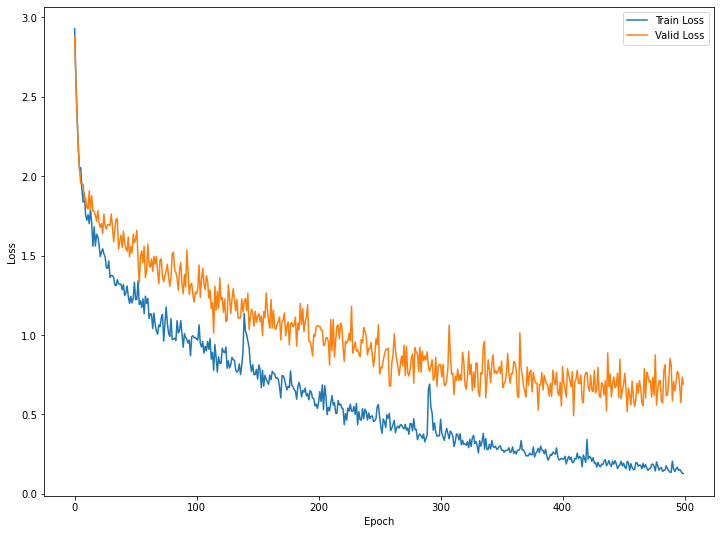

In [31]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
plt.plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [21]:
# load test data
test_image, test_label = load_data(path, subset='test')
test_mask = image2mask(test_label)

test_loader = DataLoader(
    CamVidDataset(transforms_, subset='test'),
    batch_size=len(test_image),
    drop_last=True
)

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [22]:
# test
output_list = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        # predict
        output = model(images)
        output_list.append(output)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return rgb_img_list

In [30]:
predict_test = mask2rgb(output_list[0][0])

  0%|          | 0/232 [00:00<?, ?it/s]

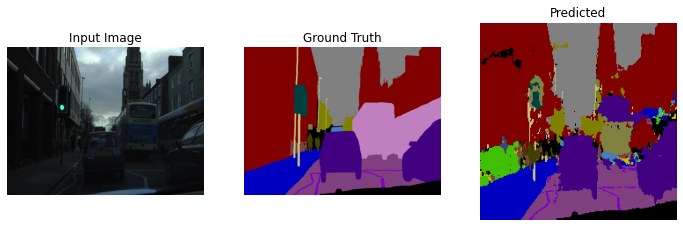

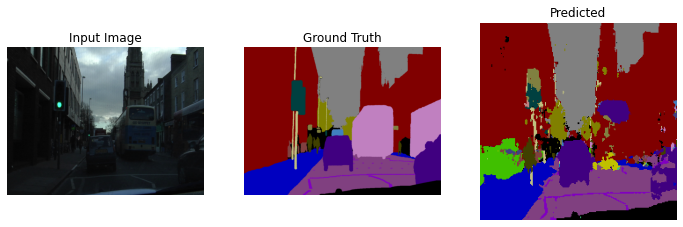

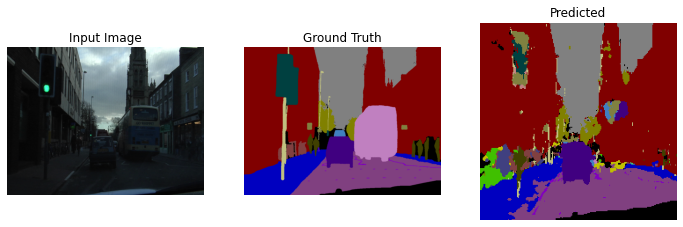

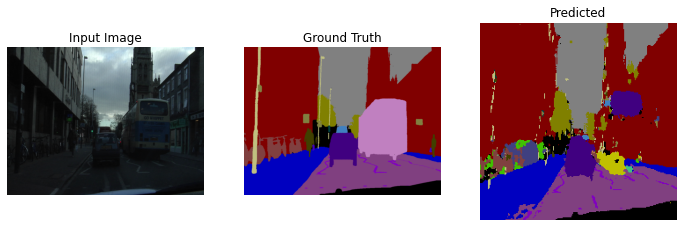

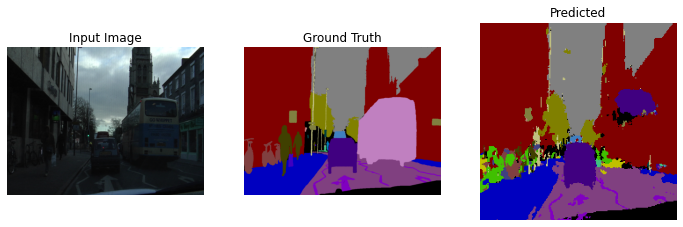

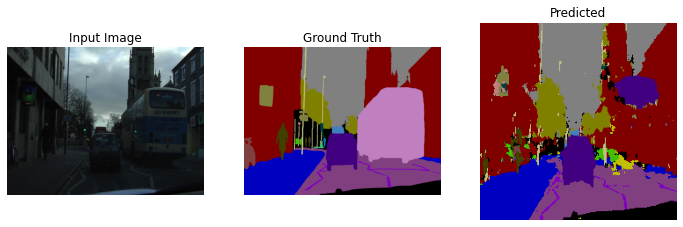

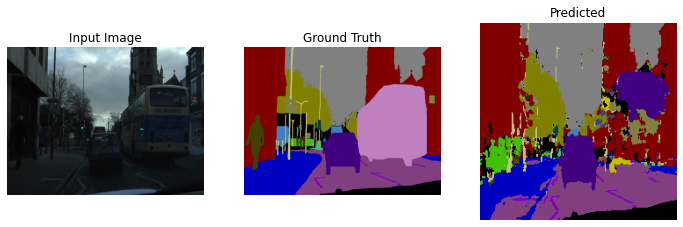

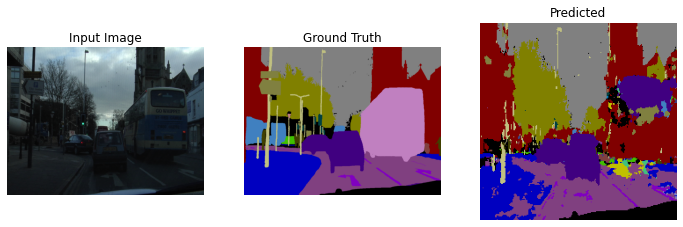

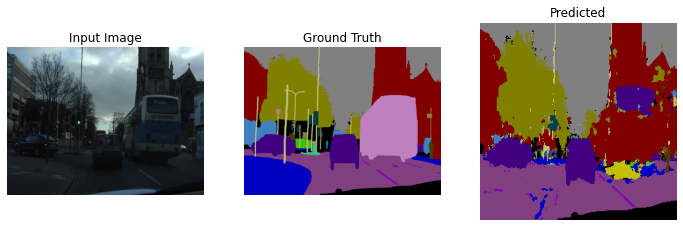

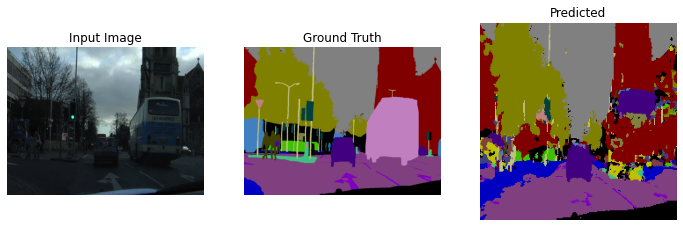

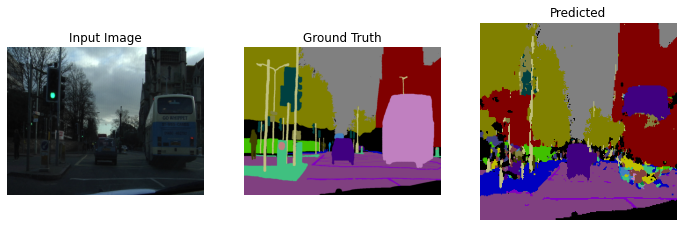

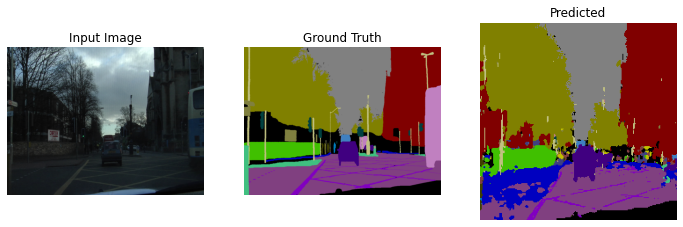

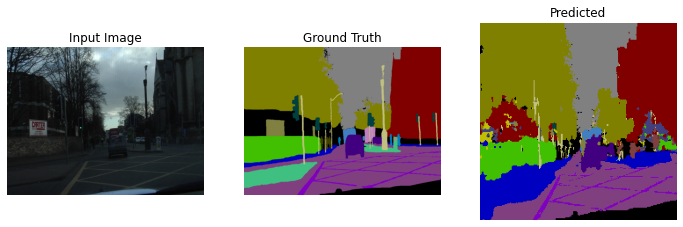

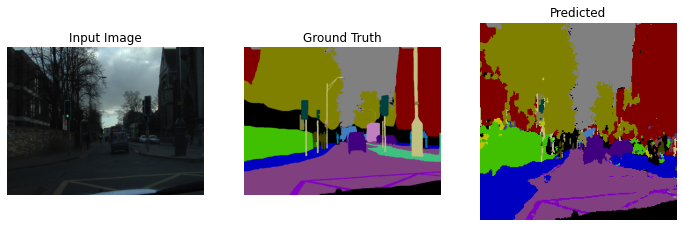

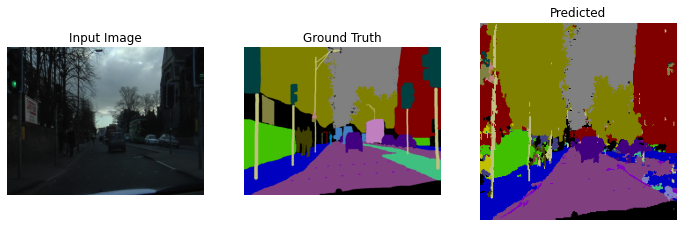

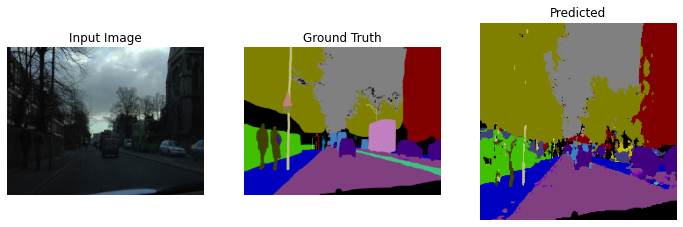

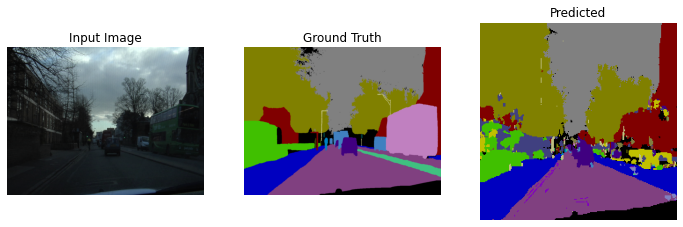

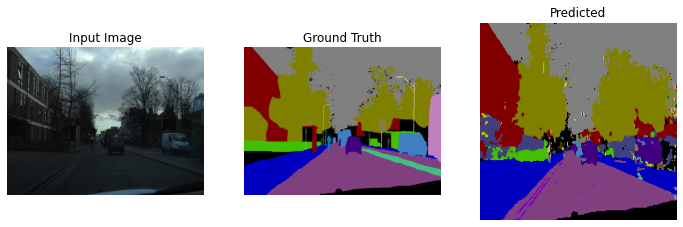

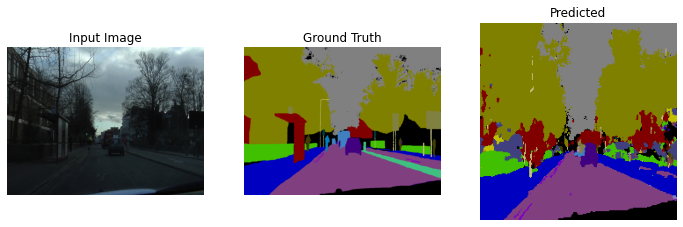

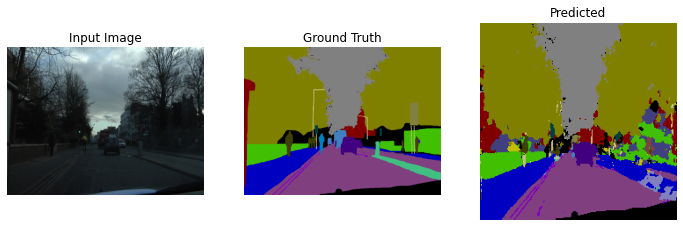

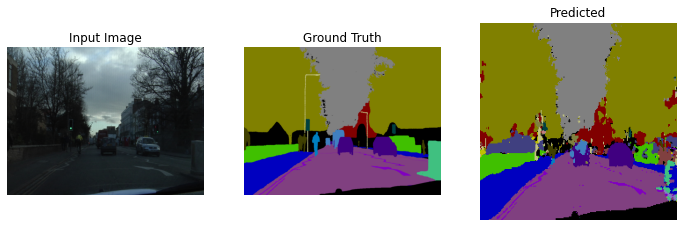

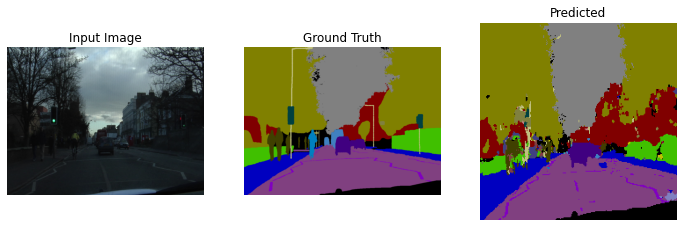

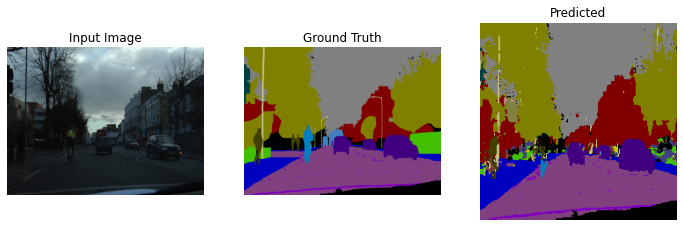

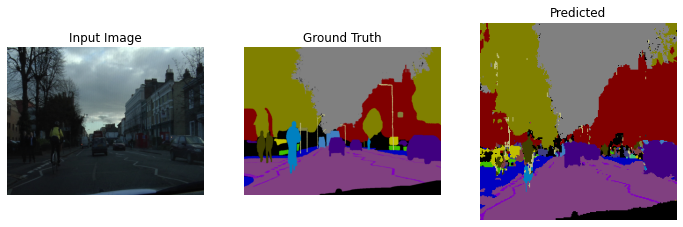

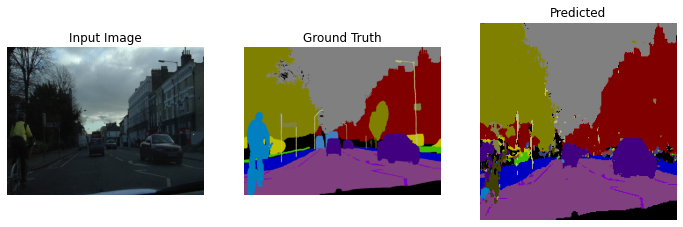

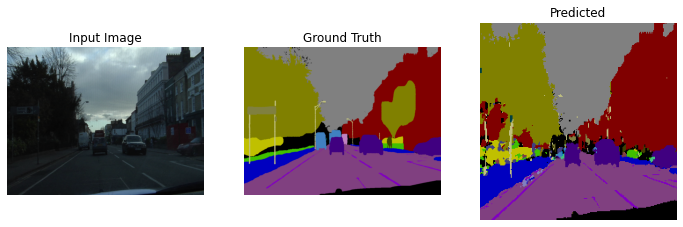

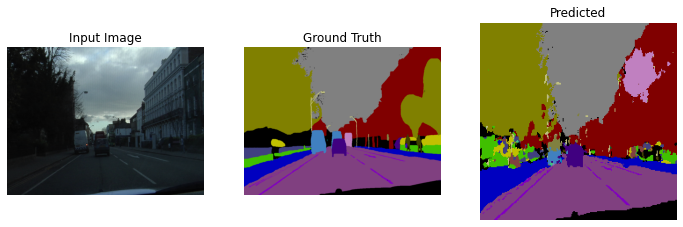

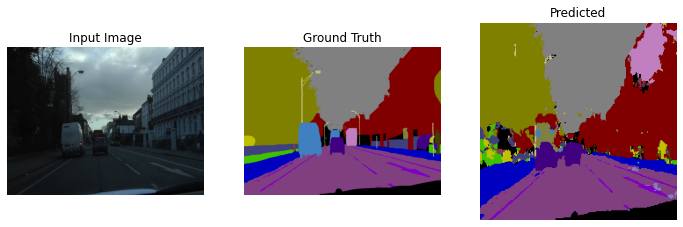

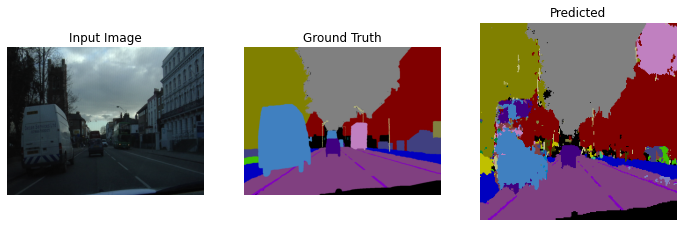

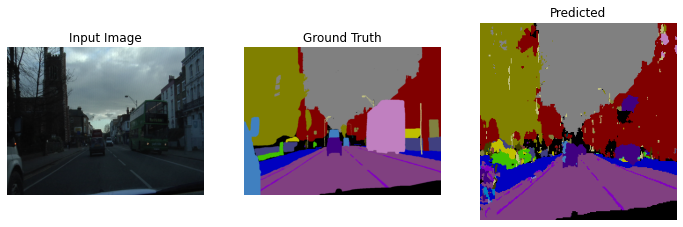

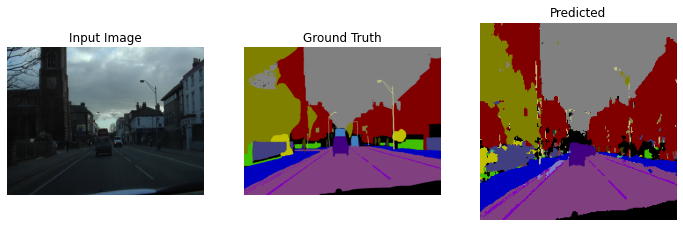

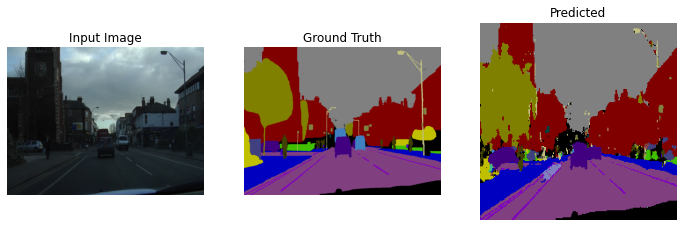

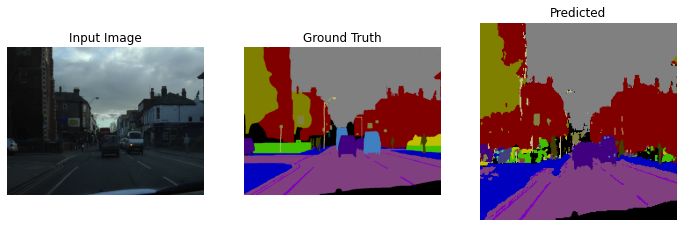

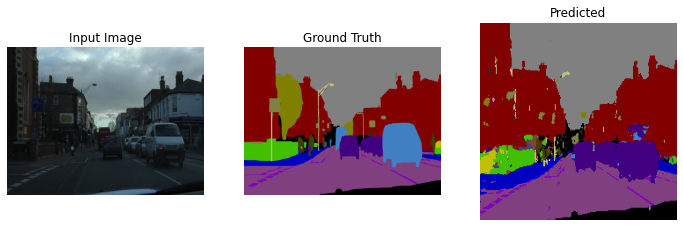

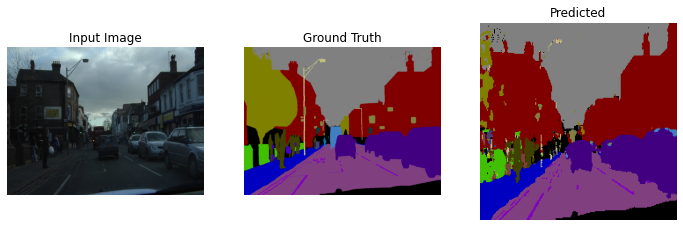

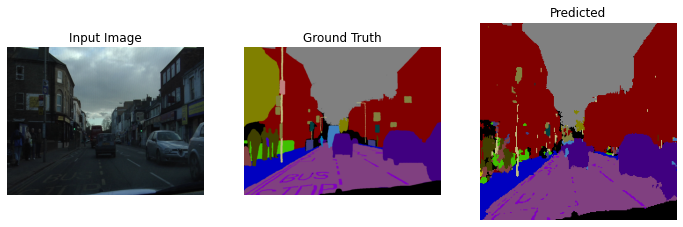

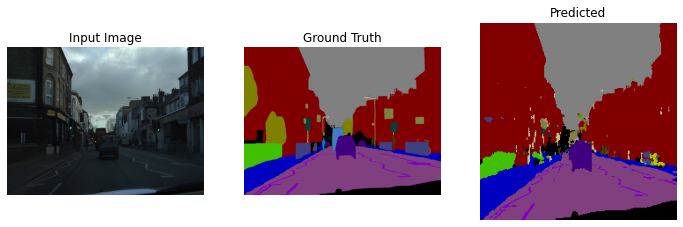

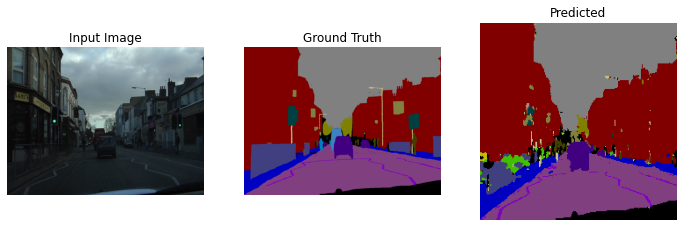

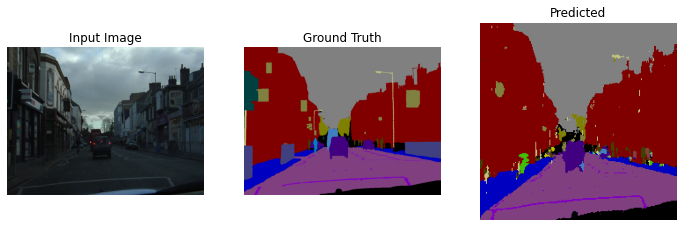

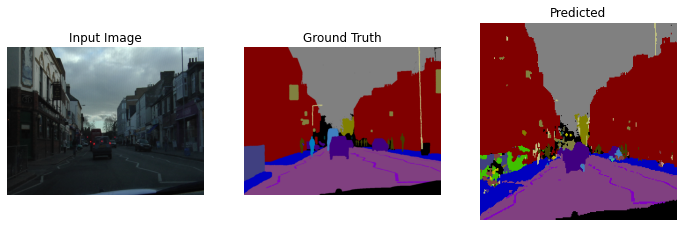

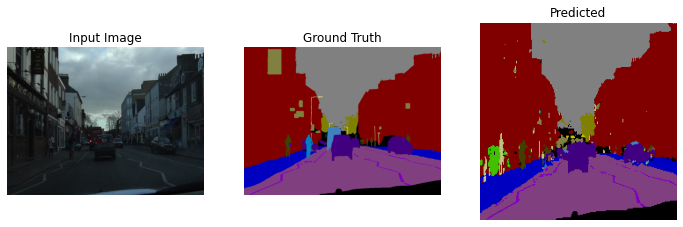

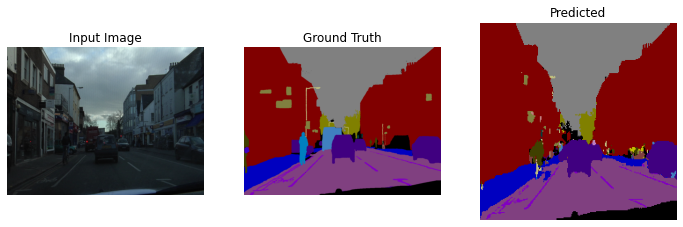

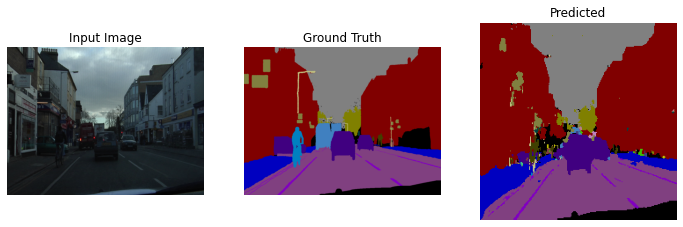

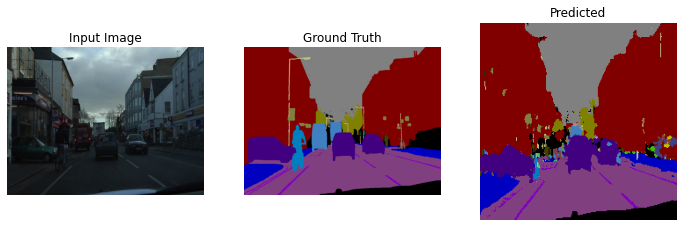

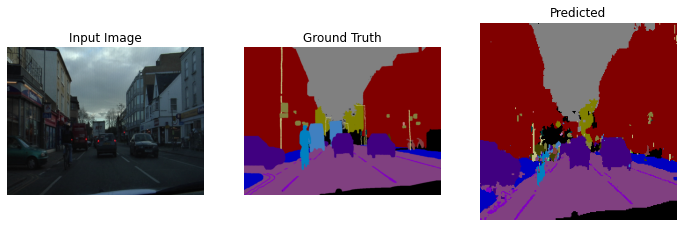

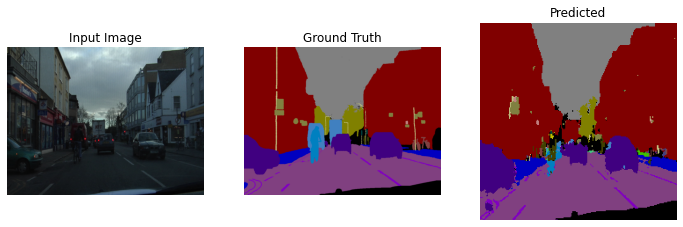

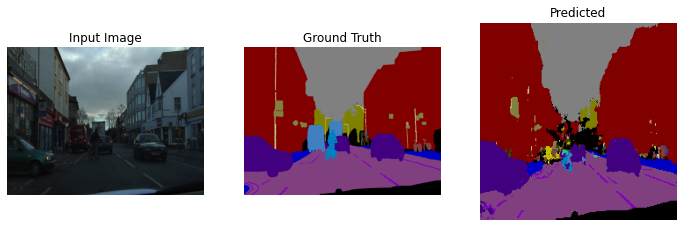

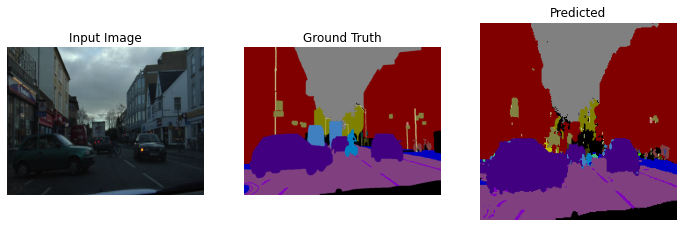

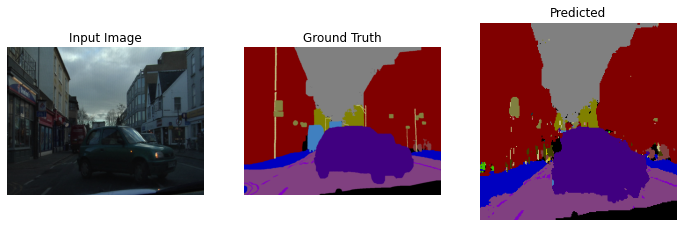

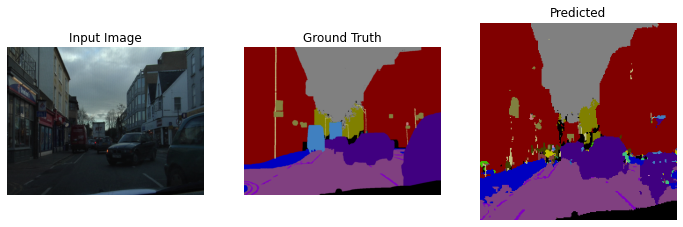

In [36]:
def show_result(image, label, result, ncols):
    for i in range(0, ncols):
        fig, ax = plt.subplots(1,3, figsize=(12,4))
        ax[0].imshow(image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(result[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted')
        fig.show()
        
show_result(test_image, test_label, predict_test, 50)